In [ ]:
import torch
import torch.nn as nn
import yaml
from yaml import Loader
from timm.scheduler.cosine_lr import CosineLRScheduler

In [15]:
class DotConfig:
    def __init__(self, cfg):
        self._cfg = cfg
    
    def __getattr__(self, k):
        v = self._cfg[k]
        if isinstance(v, dict):
            return DotConfig(v)
        return v

with open("/workspace/visiomel-2023/run/configs/swinv2_large_patch4_window12to24_192to384_22kto1k_ft.yaml", "r") as ymlfile:
    config = DotConfig(yaml.load(ymlfile, Loader=Loader))

# LR scheduler
config.TRAIN._cfg['LR_SCHEDULER'] = DotConfig({})
config.TRAIN.LR_SCHEDULER.NAME = 'cosine'
# Epoch interval to decay LR, used in StepLRScheduler
config.TRAIN.LR_SCHEDULER.DECAY_EPOCHS = 30
# LR decay rate, used in StepLRScheduler
config.TRAIN.LR_SCHEDULER.DECAY_RATE = 0.1
# warmup_prefix used in CosineLRScheduler
config.TRAIN.LR_SCHEDULER.WARMUP_PREFIX = True
# [SimMIM] Gamma / Multi steps value, used in MultiStepLRScheduler
config.TRAIN.LR_SCHEDULER.GAMMA = 0.1
config.TRAIN.LR_SCHEDULER.MULTISTEPS = []


In [35]:
model = nn.Linear(10, 10)
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-5)

n_iter_per_epoch = 1000

num_steps = int(config.TRAIN.EPOCHS * n_iter_per_epoch)
warmup_steps = int(config.TRAIN.WARMUP_EPOCHS * n_iter_per_epoch)
decay_steps = int(config.TRAIN.LR_SCHEDULER.DECAY_EPOCHS * n_iter_per_epoch)
multi_steps = [i * n_iter_per_epoch for i in config.TRAIN.LR_SCHEDULER.MULTISTEPS]

lr_scheduler = CosineLRScheduler(
    optimizer,
    t_initial=(num_steps - warmup_steps) if config.TRAIN.LR_SCHEDULER.WARMUP_PREFIX else num_steps,
    cycle_mul=1.,
    lr_min=2e-07,
    warmup_lr_init=2e-08,
    warmup_t=warmup_steps,
    cycle_limit=1,
    t_in_epochs=False,
    warmup_prefix=config.TRAIN.LR_SCHEDULER.WARMUP_PREFIX,
)

In [36]:
steps, lrs = [], []
for epoch in range(config.TRAIN.EPOCHS):
    for step in range(n_iter_per_epoch):
        t = epoch * n_iter_per_epoch + step
        lr_scheduler.step_update(t)
        steps.append(t)
        lrs.append(lr_scheduler._get_lr(t)[0])

In [37]:
import matplotlib.pyplot as plt

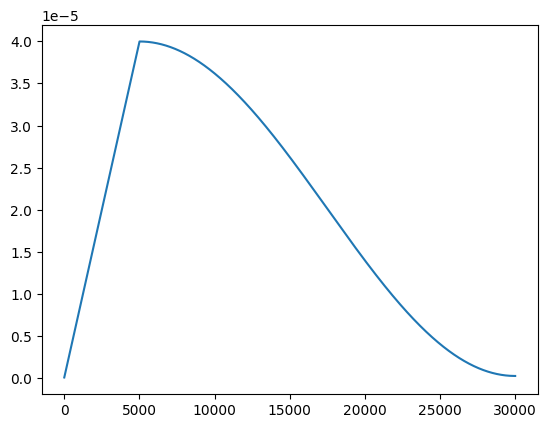

In [38]:
plt.plot(steps, lrs)

In [40]:
print(lrs[0], lrs[-1], min(lrs), max(lrs))

2e-08 2.0000015712410267e-07 2e-08 4e-05
